# Trip Duration Analysis on NYC Taxi Dataset

## Introduction
One of the most important features in the taxi data set is the trip duration so I implemented Boosted grediant regression model because of the compexity of the relationship between the features and the trip duration usig the following features:  
.The hour of the day that the trip starte at 
.The week day of the trip
.The trip distance

In [4]:
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.rdd import portable_hash
from pyspark.statcounter import StatCounter
from pyspark.sql.functions import asc,desc,col
import os
import json

from datetime import datetime
from operator import itemgetter
#from itertools import chain, imap
from shapely.geometry import shape, Point

from matplotlib import pyplot as plt

spark = SparkSession.builder.appName("taxi2")\
        .config("spark.driver.memory", "6g")\
        .config("spark.driver.cores", "4")\
        .getOrCreate()
sc=spark.sparkContext
from  pprint import pprint
def title(s):
    pprint("---- %s -----" %s)    
    
def see(s, v):
    pprint("---- %s -----" %s)
    pprint(v)

## Data Preprocessing

### Loading data into dataframe 

In [5]:
df = spark.read.csv("../data/ch08-geospatial/sample.csv", header=True)
df.toPandas()

,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,89D227B655E5C82AECF13C3F540D4CF4,BA96DE419E711691B9445D6A6307C170,CMT,1,N,2013-01-01 15:11:48,2013-01-01 15:18:10,4,382,1.00,-73.978165,40.757977,-73.989838,40.751171
1,0BD7C8F5BA12B88E0B67BED28BEA73D8,9FD8F69F0804BDB5549F40E9DA1BE472,CMT,1,N,2013-01-06 00:18:35,2013-01-06 00:22:54,1,259,1.50,-74.006683,40.731781,-73.994499,40.75066
2,0BD7C8F5BA12B88E0B67BED28BEA73D8,9FD8F69F0804BDB5549F40E9DA1BE472,CMT,1,N,2013-01-05 18:49:41,2013-01-05 18:54:23,1,282,1.10,-74.004707,40.73777,-74.009834,40.726002
3,DFD2202EE08F7A8DC9A57B02ACB81FE2,51EE87E3205C985EF8431D850C786310,CMT,1,N,2013-01-07 23:54:15,2013-01-07 23:58:20,2,244,.70,-73.974602,40.759945,-73.984734,40.759388
4,DFD2202EE08F7A8DC9A57B02ACB81FE2,51EE87E3205C985EF8431D850C786310,CMT,1,N,2013-01-07 23:25:03,2013-01-07 23:34:24,1,560,2.10,-73.97625,40.748528,-74.002586,40.747868
5,20D9ECB2CA0767CF7A01564DF2844A3E,598CCE5B9C1918568DEE71F43CF26CD2,CMT,1,N,2013-01-07 15:27:48,2013-01-07 15:38:37,1,648,1.70,-73.966743,40.764252,-73.983322,40.743763
6,496644932DF3932605C22C7926FF0FE0,513189AD756FF14FE670D10B92FAF04C,CMT,1,N,2013-01-08 11:01:15,2013-01-08 11:08:14,1,418,.80,-73.995804,40.743977,-74.007416,40.744343
7,0B57B9633A2FECD3D3B1944AFC7471CF,CCD4367B417ED6634D986F573A552A62,CMT,1,N,2013-01-07 12:39:18,2013-01-07 13:10:56,3,1898,10.70,-73.989937,40.756775,-73.86525,40.77063
8,2C0E91FF20A856C891483ED63589F982,1DA2F6543A62B8ED934771661A9D2FA0,CMT,1,N,2013-01-07 18:15:47,2013-01-07 18:20:47,1,299,.80,-73.980072,40.743137,-73.982712,40.735336
9,2D4B95E2FA7B2E85118EC5CA4570FA58,CD2F522EEE1FF5F5A8D8B679E23576B3,CMT,1,N,2013-01-07 15:33:28,2013-01-07 15:49:26,2,957,2.50,-73.977936,40.786983,-73.952919,40.80637


### Exploring the "trip_time_in_secs" column in the dataset

In [6]:
df.groupBy("trip_time_in_secs").count().orderBy(asc("trip_time_in_secs")).show()

+-----------------+-----+
|trip_time_in_secs|count|
+-----------------+-----+
|                0|  449|
|             1010|    1|
|             1020| 2136|
|             1022|    1|
|              104|    1|
|             1054|    1|
|             1059|    1|
|              107|    1|
|             1073|    2|
|             1076|    1|
|             1077|    1|
|             1080| 1916|
|             1084|    1|
|             1089|    1|
|             1094|    1|
|             1101|    1|
|             1104|    1|
|              111|    1|
|             1130|    1|
|             1136|    1|
+-----------------+-----+
only showing top 20 rows



## Exploring the "trip_distance" column in the dataset

In [7]:
df.groupBy("trip_distance").count().orderBy("trip_distance").show()

+-------------+-----+
|trip_distance|count|
+-------------+-----+
|          .00|  455|
|          .01|   36|
|          .02|   33|
|          .03|   32|
|          .04|   30|
|          .05|   46|
|          .06|   38|
|          .07|   50|
|          .08|   50|
|          .09|   65|
|          .10|   54|
|          .11|   64|
|          .12|   64|
|          .13|   47|
|          .14|   56|
|          .15|   45|
|          .16|   53|
|          .17|   42|
|          .18|   61|
|          .19|   46|
+-------------+-----+
only showing top 20 rows



### There is a lot of records with 0 distance and time 0 which may affect our analysis so I think it is better to delete them form our dataframe

In [8]:
df=df.filter((col("trip_distance")>0.2)&(col("trip_time_in_secs")>30))

In [27]:
from pyspark.sql import functions as F
df= df.withColumn("startT", F.to_timestamp(df.pickup_datetime))
df= df.withColumn("endT", F.to_timestamp(df.dropoff_datetime))

### Calculating the speed in km/h unit to give us more insights on the data

In [10]:
df=df.withColumn("speedkm/h",df.trip_distance/((df.trip_time_in_secs)/(60*60)))
df.groupBy("speedkm/h").count().orderBy(desc("speedkm/h")).show()

+------------------+-----+
|         speedkm/h|count|
+------------------+-----+
|             558.9|    1|
|              92.1|    1|
|              66.0|    1|
| 62.67142857142857|    1|
|58.199999999999996|    1|
| 57.98823529411765|    1|
|57.485714285714295|    1|
|              57.0|    2|
| 56.61176470588235|    1|
|              56.4|    2|
|             56.15|    1|
| 56.03333333333333|    1|
|             55.83|    1|
|55.371428571428574|    1|
|              55.2|    1|
|54.631578947368425|    1|
|              54.6|    1|
|54.327272727272735|    1|
|             54.27|    1|
| 54.03333333333334|    1|
+------------------+-----+
only showing top 20 rows



### Exploring the Longitude column in the dataset

In [11]:
df.groupBy("pickup_longitude").count().orderBy(desc("pickup_longitude")).show()

+----------------+-----+
|pickup_longitude|count|
+----------------+-----+
|               0| 1466|
|      -98.116669|    1|
|       -74.51667|    1|
|      -74.342957|    1|
|      -74.267281|    1|
|      -74.266434|    1|
|       -74.23333|    1|
|      -74.168175|    1|
|      -74.167603|    1|
|      -74.161942|    1|
|      -74.161301|    1|
|      -74.159859|    2|
|        -74.1465|    1|
|      -74.144005|    1|
|      -74.126396|    1|
|      -74.125938|    1|
|      -74.112953|    1|
|      -74.105057|    1|
|      -74.102722|    1|
|      -74.091644|    1|
+----------------+-----+
only showing top 20 rows



### Deleting the rows that contains 0 longitude or latitude or speed higher than 100 km/h

In [26]:
df=df.filter((col("speedkm/h")<100)&(col("pickup_longitude")!=0)&(col("pickup_latitude")!=0)
             &(col("dropoff_longitude")!=0)&(col("dropoff_latitude")!=0))

In [13]:
# from pyspark.sql.functions import udf
# from pyspark.sql.types import StringType
# def point(long,lat):
#     return str(long)+","+str(lat)
# point_udf=udf(point,StringType())
# df=df.withColumn("pickup_point",point_udf(df.pickup_longitude,df.pickup_latitude)

### Adding the hour and day of the trip

In [69]:
def time_weekday(row):
    row=row.asDict()
    row['hour']=row['startT'].hour
    row['day']=row['startT'].weekday()
    return row
taxiRDD=df.rdd.map(time_weekday)

In [70]:
taxiDF=taxiRDD.toDF()

/usr/local/spark/python/pyspark/sql/session.py:351: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "


### Exploring the trip average speed on every hour of the day

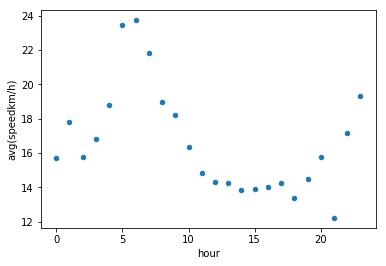

In [18]:
#spped by day 
speed_hour=taxiDF.groupBy(taxiDF.hour).agg(F.avg("speedkm/h")).toPandas()
plt.clf()
speed_hour.plot(x='hour', y='avg(speedkm/h)', kind='scatter')
plt.show()

### Exploring the trip average speed for every day

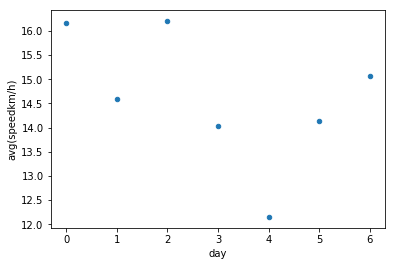

In [72]:
speed_day=taxiDF.groupBy(taxiDF.day).agg(F.avg("speedkm/h")).toPandas()
plt.clf()
speed_day.plot(x='day', y='avg(speedkm/h)', kind='scatter')
plt.show()

#### From the two plots it seems that the speed has some sort of relationship with the hour and the day but it can't be fitted using linear regression.

## 2.Modeling

### Selecting the needed features for predicting the trip duratin in minutes which are("day","hour","trip_distance",""trip_distance""), then splitting the data into traing/ testing sets

In [53]:
from pyspark.sql.functions import col, round
taxiDF=taxiDF.withColumn("trip_time_in_min",round(col("trip_time_in_secs")/60,2))
taxiDF=taxiDF.select("day","hour","trip_distance","trip_time_in_min")
taxiDF=taxiDF.select([col(c).cast("double").alias(c) for c in taxiDF.columns])
train, test = taxiDF.randomSplit([0.7, 0.3])

In [54]:
taxiDF.select("trip_time_in_min").show()

+----------------+
|trip_time_in_min|
+----------------+
|            6.37|
|            4.32|
|             4.7|
|            4.07|
|            9.33|
|            10.8|
|            6.97|
|           31.63|
|            4.98|
|           15.95|
|            7.95|
|            12.8|
|           10.33|
|            10.2|
|           21.55|
|           17.88|
|            9.85|
|            2.63|
|            4.37|
|           11.15|
+----------------+
only showing top 20 rows



### Using VectorAssembler, VectorIndexer to prepare the dataset for the "GBTRegressor"

In [56]:
from pyspark.ml.feature import VectorAssembler, VectorIndexer
featuresCols = taxiDF.columns
featuresCols.remove('trip_time_in_min')
# This concatenates all feature columns into a single feature vector in a new column "rawFeatures".
vectorAssembler = VectorAssembler(inputCols=featuresCols, outputCol="rawFeatures")
# This identifies categorical features and indexes them.
vectorIndexer = VectorIndexer(inputCol="rawFeatures", outputCol="features", maxCategories=24)


In [57]:
from pyspark.ml.regression import GBTRegressor
# Takes the "features" column and learns to predict "cnt"
gbt = GBTRegressor(labelCol="trip_time_in_min")


### Entering the hyperparameters for our model and using "rmse"(root mean squared error) to evaluate our model

In [58]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
# Define a grid of hyperparameters to test:
#  - maxDepth: max depth of each decision tree in the GBT ensemble
#  - maxIter: iterations, i.e., number of trees in each GBT ensemble
# In this example notebook, we keep these values small.  In practice, to get the highest accuracy, you would likely want to try deeper trees (10 or higher) and more trees in the ensemble (>100).
paramGrid = ParamGridBuilder()\
  .addGrid(gbt.maxDepth, [2, 5])\
  .addGrid(gbt.maxIter, [10, 120])\
  .build()
# We define an evaluation metric.  This tells CrossValidator how well we are doing by comparing the true labels with predictions.
evaluator = RegressionEvaluator(metricName="rmse", labelCol=gbt.getLabelCol(), predictionCol=gbt.getPredictionCol())
# Declare the CrossValidator, which runs model tuning for us.
cv = CrossValidator(estimator=gbt, evaluator=evaluator, estimatorParamMaps=paramGrid)


In [59]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[vectorAssembler, vectorIndexer, cv])

### Fitting our model on the train set

In [60]:
pipelineModel = pipeline.fit(train)

### Using the fitted model on the test set

In [61]:
predictions = pipelineModel.transform(test)

In [62]:
predictions.select("trip_time_in_min", "prediction").show()

+----------------+------------------+
|trip_time_in_min|        prediction|
+----------------+------------------+
|            3.13| 3.863752711548708|
|            10.2| 8.132481228059191|
|             5.7| 5.309521930131123|
|            7.43| 6.186989394787973|
|           15.95|12.913433619496256|
|           19.65|28.912256553159622|
|            4.57| 3.645300376518035|
|            7.65| 5.275542628884727|
|            7.42|  6.71346709767532|
|           14.57| 9.241063146992419|
|           12.07|10.968643171304432|
|            5.53| 8.086267905948318|
|            8.43| 9.005925848323962|
|           14.18| 9.547817906833997|
|            9.47| 6.670907338351446|
|             4.0| 4.331180267321153|
|           24.28| 28.67199540505481|
|            4.07| 4.790214330867865|
|            7.25| 9.750023267117353|
|            4.98| 6.114671789669986|
+----------------+------------------+
only showing top 20 rows



#### It seems that most of the predicted values is close to the values in the test set so our model has worked fine enough.

### Getting the rmse

In [63]:
evaluator.evaluate(predictions)

3.771744771803852

The rmse is relatively low 

### Visualizing the predicted values vs the target values

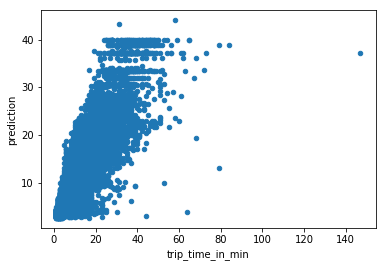

In [65]:
prediction_df=predictions.select("trip_time_in_min", "prediction").toPandas()
plt.clf()
prediction_df.plot(x='trip_time_in_min', y='prediction', kind='scatter')
plt.show()